In [10]:
import numpy as np

# Preprocessing

We need to get the data from tensorflow format to pytorch

In [11]:
# we need to import all the tfrecord files

import glob

is_local = True
if is_local:
    train_path = 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\*.tfrec'
    val_path = 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\val\\*.tfrec'
    test_path = 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\test\\*.tfrec'
else:
    train_path = '/kaggle/input/tpu-getting-started/*/train/*.tfrec'
    val_path = '/kaggle/input/tpu-getting-started/*/val/*.tfrec'
    test_path = '/kaggle/input/tpu-getting-started/*/test/*.tfrec'

train_files = glob.glob(train_path)
val_files = glob.glob(val_path)
test_files = glob.glob(test_path)
train_files[:5]

['kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\00-192x192-798.tfrec',
 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\01-192x192-798.tfrec',
 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\02-192x192-798.tfrec',
 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\03-192x192-798.tfrec',
 'kaggle\\input\\tpu-getting-started\\tfrecords-jpeg-192x192\\train\\04-192x192-798.tfrec']

In [12]:
import tensorflow as tf

train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, train_feature_description)

In [4]:
train_ids = []
train_class = []
train_images = []
for i in train_files:
    train_image_dataset = tf.data.TFRecordDataset(i)
    train_image_dataset = train_image_dataset.map(_parse_image_function)
    ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
    train_ids = train_ids + ids
    classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
    train_class = train_class + classes
    images = [image_features['image'].numpy() for image_features in train_image_dataset]
    train_images = train_images + images

In [13]:
val_ids = []
val_class = []
val_images = []
for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)
    val_image_dataset = val_image_dataset.map(_parse_image_function)
    ids = [str(id_features['id'].numpy())[2:-1] for id_features in val_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in val id names
    val_ids = val_ids + ids
    classes = [int(class_features['class'].numpy()) for class_features in val_image_dataset]
    val_class = val_class + classes
    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images = val_images + images

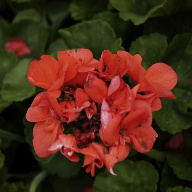

In [10]:
"""import IPython.display as display
display.display(display.Image(data=train_images[0]))"""

In [14]:
from PIL import Image
import cv2
import albumentations
import torch
import numpy as np
import io
from torch.utils.data import Dataset

In [17]:
class FlowerDataset(Dataset):
    def __init__(self, id, classes, image, img_height, img_width, mean, std):
        self.id = id
        self.classes = classes
        self.image = image
        

        self.aug = albumentations.Compose([
            albumentations.Resize(img_height, img_width),
            albumentations.Normalize(mean, std, always_apply=True)])

    def __len__(self):
        return len(self.id)

    def __getitem__(self, index):
        id = self.id[index]
        img = np.array(Image.open(io.BytesIO(self.image[index])))
        img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        img = self.aug(image=img)["image"]
        img = np.transpose(img, (2,0,1)).astype(np.float32)

        return torch.tensor(img, dtype=torch.float), int(self.classes[index])        

In [18]:
td = FlowerDataset(
    id = train_ids, 
    classes = train_class, 
    image = train_images,
    img_height = 128,
    img_width=128,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
)
vd = FlowerDataset(
    id = val_ids, 
    classes = val_class, 
    image = val_images,
    img_height = 128,
    img_width=128,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
)

In [8]:
len(td)

12753

In [9]:
torch.save(td, f="train_dataset.pt")